In [1]:
import os
import json
import torch
from termcolor import cprint

In [2]:
def summary_stats(nums):
    total = sum(nums)
    mean = total / len(nums)

    variance = sum([(mean - x)**2 for x in nums]) / (len(nums) - 1)
    return mean, variance ** 0.5

In [3]:
grid_vals = [0, 2.5e-5, 2.5e-4, 2.5e-3, 2.5e-2, 2.5e-1, 2.5, 25]

winners = []

gridValData = {}

for name in sorted(os.listdir("grid_search_weight_decay")):
    if name[0] == ".": continue# or not name.startswith("fastvit_ma36"): continue

    print(name)
    modelData = {}
    
    path = f"grid_search_weight_decay/{name}"
    aucs_path = path + "/objects/curve_and_auc_sigmoid/"

    names = []
    means = []
    stds = []

    zero_path = f"weight_decay_zero/{name}/objects/curve_and_auc_sigmoid/0-fold_roc_auc.pth"
    data = torch.load(zero_path, weights_only=False)

    mean, std = summary_stats([o["auc"] for o in data])
    names.append("zero_manual")
    means.append(mean)
    stds.append(std)
    
    for i, filename in enumerate(sorted(os.listdir(aucs_path)), start=1):
        auc_path = aucs_path + filename
        data = torch.load(auc_path, weights_only=False)
        mean, std = summary_stats([ o["auc"] for o in data])

        names.append(filename)
        means.append(mean)
        stds.append(std)

    large_path = f"weight_decay_large/{name}/objects/curve_and_auc_sigmoid/0-fold_roc_auc.pth"
    data = torch.load(large_path, weights_only=False)

    mean, std = summary_stats([o["auc"] for o in data])
    names.append("large_manual")
    means.append(mean)
    stds.append(std)

    large_path = f"weight_decay_larger/{name}/objects/curve_and_auc_sigmoid/0-fold_roc_auc.pth"
    data = torch.load(large_path, weights_only=False)

    mean, std = summary_stats([o["auc"] for o in data])
    names.append("larger_manual")
    means.append(mean)
    stds.append(std)

    mean_sorted = sorted(means)
    std_sorted = sorted(stds)

    winner = None

    for i in range(len(names)):
        print(grid_vals[i], end="\t\t")

        if means[i] == mean_sorted[-1]:
            cprint(means[i], "green", end="\t")
            if winner is None:
                zero_path = f"weight_decay_zero/{name}/objects/logits/0-fold-logits.pth"
                decay_path = f"grid_search_weight_decay/{name}/objects/logits/{i-1}-fold-logits.pth"
                large_path = f"weight_decay_large/{name}/objects/logits/0-fold-logits.pth"

                zero_weights = [ f"weight_decay_zero/{name}/objects/checkpoints/0-fold-{f}-state.pth" for f in range(5) ]
                decay_weights = [ f"grid_search_weight_decay/{name}/objects/checkpoints/{i-1}-fold-{f}-state.pth" for f in range(5) ]
                large_weights = [ f"weight_decay_large/{name}/objects/checkpoints/0-fold-{f}-state.pth" for f in range(5) ]

                winner = {
                    "grid_idx": i,
                    "name": name,
                    "weight_decay": grid_vals[i],
                    "mean": means[i].item(),
                    "std": stds[i].item(),
                    "logits": zero_path if i == 0 else large_path if i == 6 else decay_path,
                    "weights": zero_weights if i == 0 else large_weights if i == 6 else decay_weights 
                }
        elif means[i] == mean_sorted[-2]:
            cprint(means[i], "yellow", end="\t")
        else:
            print(means[i], end="\t")
            
        if stds[i] == std_sorted[0]:
            cprint(stds[i], "green")
        else:
            print(stds[i])
        modelData[grid_vals[i]] = means[i].item()
        
    gridValData[name] = modelData

    winners.append(winner)

    print("-"*65)

convnextv2_nano
0		0.7919452361913424	0.06448426577221046
2.5e-05		0.7919452361913424	0.06448426577221046
0.00025		0.7919452361913424	0.06448426577221046
0.0025		0.7444748604863073	0.08324993640520821
0.025		0.8198331823097258	0.12292141694976638
0.25		0.7484067150280324	0.03654219841695557
2.5		0.8381306010457822	0.09031020512304658
25		0.5	0.0
-----------------------------------------------------------------
convnextv2_tiny
0		0.6533936392293965	0.12789297710637568
2.5e-05		0.6533936392293965	0.12789297710637568
0.00025		0.6533936392293965	0.12789297710637568
0.0025		0.7679958998217582	0.13168745378157093
0.025		0.7012714757824066	0.06336983255311572
0.25		0.7143362611062931	0.18202070463456177
2.5		0.6765842897692211	0.16792540148241525
25		0.5	0.0
-----------------------------------------------------------------
efficientnetv2_m
0		0.9470648871802935	0.015010450303471848
2.5e-05		0.9470648871802935	0.015010450303471848
0.00025		0.9470648871802935	0.015010450303471848
0.0025		0.9507

In [4]:
with open("grid_winners-weights.json", "w") as file:
    json.dump(winners, file)

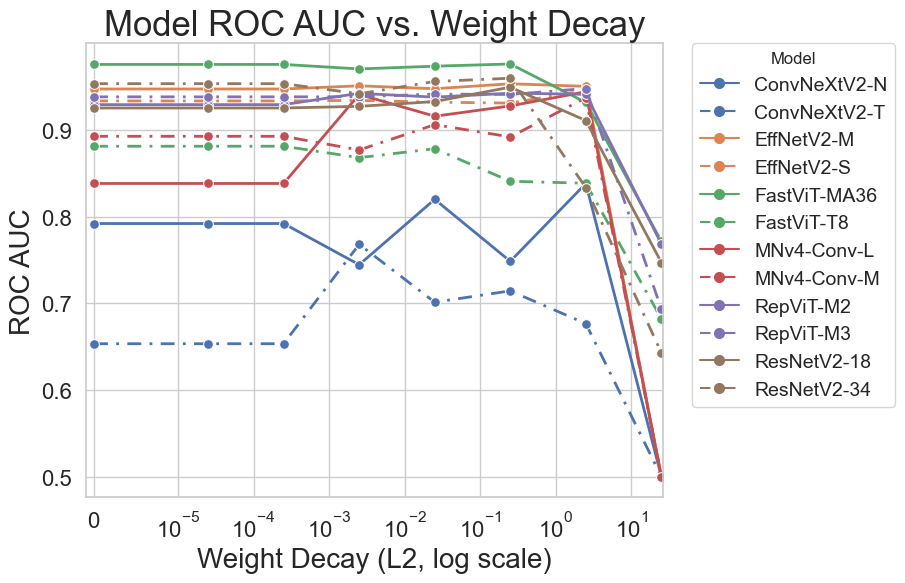

In [6]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # We need this to build the legend

model_group_mapping = {
    'convnextv2_nano': 'ConvNext',
    'convnextv2_tiny': 'ConvNext',
    'efficientnetv2_m': 'EfficientNet',
    'efficientnetv2_s': 'EfficientNet',
    'fastvit_ma36': 'FastViT',
    'fastvit_t8': 'FastViT',
    'mobilenetv4_conv_large': 'MobileNet',
    'mobilenetv4_conv_medium': 'MobileNet',
    'repvit_m2.native': 'RepViT',
    'repvit_m3.native': 'RepViT',
    'resnetv2_18': 'ResNet',
    'resnetv2_34': 'ResNet'
}

modelGroupCommonNames = {
    'convnextv2_nano': 'ConvNeXtV2-N',
    'convnextv2_tiny': 'ConvNeXtV2-T',
    'efficientnetv2_s': 'EffNetV2-S',
    'efficientnetv2_m': 'EffNetV2-M',
    'fastvit_t8': 'FastViT-T8',
    'fastvit_ma36': 'FastViT-MA36',
    'mobilenetv4_conv_medium': 'MNv4-Conv-M',
    'mobilenetv4_conv_large': 'MNv4-Conv-L',
    'repvit_m2.native': 'RepViT-M2',
    'repvit_m3.native': 'RepViT-M3',
    'resnetv2_18': 'ResNetV2-18',
    'resnetv2_34': 'ResNetV2-34'
}

df_wide = pd.DataFrame(gridValData).T
# Stack the DataFrame to "unpivot" it, creating a long-form Series
df_long_series = df_wide.stack()
# Reset the index to turn the indices (Model, Parameter) into columns
df = df_long_series.reset_index()
# Rename columns for clarity
df.columns = ['Model', 'Weight Decay (L2)', 'ROC AUC']

df['Model Group'] = df['Model'].map(model_group_mapping)

style_patterns = [
    (),              # Solid
    (5, 3, 1, 3)     # Dash-dot
]

dashes_map = {}
# Go through each group one by one
for group in df['Model Group'].unique():
    # Find all models *within that group*
    models_in_group = df[df['Model Group'] == group]['Model'].unique()
    models_in_group.sort() # Ensure consistent order
    
    # Assign a style to each model, cycling through the patterns
    for i, model_name in enumerate(models_in_group):
        style_index = i % len(style_patterns)
        dashes_map[model_name] = style_patterns[style_index]

unique_groups = sorted(df['Model Group'].unique())
palette = sns.color_palette(n_colors=len(unique_groups))
color_map = dict(zip(unique_groups, palette))

# 2. Plot the data
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(11, 6)) # Get fig and ax objects

ax = sns.lineplot(
    data=df,
    x='Weight Decay (L2)',
    y='ROC AUC',
    hue='Model Group',  
    style='Model', 
    dashes=dashes_map,  
    marker='o',
    markersize=7,
    linewidth=2,
    legend = False,
    ax=ax
)

legend_handles = []

for group in unique_groups:
    models_in_group = sorted(df[df['Model Group'] == group]['Model'].unique())
    for model_name in models_in_group:
        handle = Line2D(
            [0], [0],
            color=color_map[group],
            dashes=dashes_map[model_name],     # Your custom dash pattern
            marker='o',
            markersize=7,
            linewidth=1.5,
            label=modelGroupCommonNames[model_name]
        )
        legend_handles.append(handle)

ax.legend(
    handles=legend_handles,
    title='Model',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize = 14
)


# 3. Set the x-axis to a "symmetrical log" scale
# This handles the '0' value gracefully while keeping other values on a log scale
ax.set_xscale('symlog', linthresh=1e-5) # linthresh sets the linear range around zero
ax.set_xlim(left=-1e-6)

ax.tick_params(axis='both', labelsize=16) 

# Add title and labels
ax.set_title('Model ROC AUC vs. Weight Decay', fontsize=25)
ax.set_xlabel('Weight Decay (L2, log scale)', fontsize=20)
ax.set_ylabel('ROC AUC', fontsize=20)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Sanity Check AUC of a particular fold

In [225]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import timm
import json
import torch.utils.data
from load_dataset import make_dataset

In [226]:
with open(base_path + f"{GRID_IDX}-dataset_settings.json", "r") as file:
    dataset_settings = json.loads(file.read())

BASE_DIR = "/home/nhchoi1/xrays/data"
IMAGE_DIR = "/home/nhchoi1/xrays/data/images"

dataset = make_dataset(BASE_DIR, IMAGE_DIR, 
                       image_size=(224, 224),
                       label_map=dataset_settings["label_map"])

In [253]:
RUN = "grid_search_weight_decay"
MODEL = "resnetv2_34"
MODEL_NAME = "resnetv2_34"
GRID_IDX = 4
FOLD_IDX = 4

In [254]:
base_path = f"{RUN}/{MODEL}/objects/"
checkpoint = base_path + f"checkpoints/{GRID_IDX}-fold-{FOLD_IDX}-state.pth"

weights = torch.load(checkpoint)

In [255]:
model = timm.create_model(MODEL_NAME, num_classes=1)
model.load_state_dict(weights)

<All keys matched successfully>

In [256]:
test_indices = torch.load(base_path + f"indices/{GRID_IDX}_fold_{FOLD_IDX}_test_indices.arr", weights_only=False)
test_subset = torch.utils.data.Subset(dataset, test_indices)

test_loader = torch.utils.data.DataLoader(test_subset, batch_size = 2048, shuffle=False)

In [257]:
model.to("cuda:1")
model.eval()

with torch.no_grad():
    y_true = []
    y_scores = []
    
    for inputs, labels in test_loader:
        inputs = inputs.type(torch.float).to("cuda:1")
        labels = labels.type(torch.float).to("cuda:1")
    
        output = torch.sigmoid(model(inputs)).reshape(-1)
        output = model(inputs).reshape(-1)
    
        y_scores.extend(output.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_true = np.array(y_true).flatten()
y_scores = np.array(y_scores).flatten()

In [258]:
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)
sums.append(roc_auc)

AUC: 0.96996996996997


In [263]:
sum(sums)/5

0.9594601004645102

# Recalc AUCs with Sigmoid
Found that there are actually some differences using raw logits and sigmoid because of floating point truncation

In [5]:
from sklearn.metrics import roc_curve, auc

In [6]:
def metric_dict(y_true, y_logits):
    y_scores = torch.sigmoid(torch.from_numpy(y_logits))
    
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_val = auc(fpr, tpr)

    return { "fpr": fpr, "tpr": tpr, "auc": auc_val }

In [10]:
RUNS = "weight_decay_larger"

for name in sorted(os.listdir(RUNS)):
    if name[0] == ".":
        continue

    all_logits_path = f"{RUNS}/{name}/objects/logits/"
    all_aucs_path = f"{RUNS}/{name}/objects/curve_and_auc/"

    output_path = f"{RUNS}/{name}/objects/curve_and_auc_sigmoid/"

    os.makedirs(output_path, exist_ok=True)

    for logits_path, aucs_path in zip(sorted(os.listdir(all_logits_path)), sorted(os.listdir(all_aucs_path))):
        grid_logits = torch.load(os.path.join(all_logits_path, logits_path), weights_only=False)
        grid_aucs = torch.load(os.path.join(all_aucs_path, aucs_path), weights_only=False)

        metrics = [metric_dict(*numbers) for numbers in grid_logits]

        print(metrics)

        torch.save(metrics, os.path.join(output_path, aucs_path))

[{'fpr': array([0., 1.]), 'tpr': array([0., 1.]), 'auc': np.float64(0.5)}, {'fpr': array([0., 1.]), 'tpr': array([0., 1.]), 'auc': np.float64(0.5)}, {'fpr': array([0., 1.]), 'tpr': array([0., 1.]), 'auc': np.float64(0.5)}, {'fpr': array([0., 1.]), 'tpr': array([0., 1.]), 'auc': np.float64(0.5)}, {'fpr': array([0., 1.]), 'tpr': array([0., 1.]), 'auc': np.float64(0.5)}]
[{'fpr': array([0., 1.]), 'tpr': array([0., 1.]), 'auc': np.float64(0.5)}, {'fpr': array([0., 1.]), 'tpr': array([0., 1.]), 'auc': np.float64(0.5)}, {'fpr': array([0., 1.]), 'tpr': array([0., 1.]), 'auc': np.float64(0.5)}, {'fpr': array([0., 1.]), 'tpr': array([0., 1.]), 'auc': np.float64(0.5)}, {'fpr': array([0., 1.]), 'tpr': array([0., 1.]), 'auc': np.float64(0.5)}]
[{'fpr': array([0., 1.]), 'tpr': array([0., 1.]), 'auc': np.float64(0.5)}, {'fpr': array([0., 1.]), 'tpr': array([0., 1.]), 'auc': np.float64(0.5)}, {'fpr': array([0., 1.]), 'tpr': array([0., 1.]), 'auc': np.float64(0.5)}, {'fpr': array([0., 1.]), 'tpr': arr

# Make the ensemble model!

In [177]:
with open("grid_winners.json", "r") as file:
    winners_data = json.load(file)

In [179]:
winners_data

[{'grid_idx': 4,
  'name': 'convnextv2_nano',
  'weight_decay': 0.025,
  'mean': 0.8198331823097258,
  'std': 0.12292141694976638,
  'logits': 'grid_search_weight_decay/convnextv2_nano/objects/3-fold-logits.pth'},
 {'grid_idx': 3,
  'name': 'convnextv2_tiny',
  'weight_decay': 0.0025,
  'mean': 0.7679958998217582,
  'std': 0.13168745378157093,
  'logits': 'grid_search_weight_decay/convnextv2_tiny/objects/2-fold-logits.pth'},
 {'grid_idx': 5,
  'name': 'efficientnetv2_m',
  'weight_decay': 0.25,
  'mean': 0.95310707827362,
  'std': 0.013609475777101143,
  'logits': 'grid_search_weight_decay/efficientnetv2_m/objects/4-fold-logits.pth'},
 {'grid_idx': 3,
  'name': 'efficientnetv2_s',
  'weight_decay': 0.0025,
  'mean': 0.9339188527052104,
  'std': 0.021599880284314095,
  'logits': 'grid_search_weight_decay/efficientnetv2_s/objects/2-fold-logits.pth'},
 {'grid_idx': 5,
  'name': 'fastvit_ma36',
  'weight_decay': 0.25,
  'mean': 0.9758976817876237,
  'std': 0.011613085407095344,
  'logits':

In [183]:
for winner in winners_data:
    print(winner["name"])
    

convnextv2_nano
convnextv2_tiny
efficientnetv2_m
efficientnetv2_s
fastvit_ma36
fastvit_t8
mobilenetv4_conv_large
mobilenetv4_conv_medium
repvit_m2.native
repvit_m3.native
resnetv2_18
resnetv2_34
